# Home2
Your home away from home <br>
The best location for your needs, anywhere in the world <br>
### Inputs: 
    Addresses (eg. 'Pune, Maharashtra')
    Category List (eg. 'Food', 'Restaurant', 'Gym', 'Trails', 'School', 'Train Station')
    Limit of Results to return (eg. 75)
    Radius of search in metres (eg. 10,000)
    Radiums of hotels to search
### Outputs:
    Cluster of venues coded by criteria
    map of cluster
    Centroid latitude and longitude for these venues
    Address near centroid
    Hotels near centroid

## User Input

In [1]:
# Addresses to analyze venues around and obtain best location
addresses=['Bend, Oregon'] 
# 4square Venue categories of interest (https://developer.foursquare.com/docs/build-with-foursquare/categories)
categories=['4bf58dd8d48988d181941735','4bf58dd8d48988d149941735','4bf58dd8d48988d176941735','53e510b7498ebcb1801b55d4',
           '52e81612bcbc57f1066b7a21','5bae9231bedf3950379f89d0','4bf58dd8d48988d159941735']  
# Limit of search results  
LIMIT=500
# Radius of search in metres (maximum 100000)
radius=20000
# Radius in metres to search hotels around from final optimum location (centroid). This list is also sorted by likes    
hotel_radius=20000 
# Remove Outliers? 'Y' or 'N'
remove_outliers='Y'

## Import Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import math

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
 
! pip install lxml

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Obtain Location and Venue information in a Dataframe

### Create Geolocator using Nominatim and Obtain Location info. for the addresses

In [3]:
geoagent="explorer"

lat=[]
long=[]
for address in addresses:
    geolocator = Nominatim(user_agent=geoagent)
    loc = geolocator.geocode(address)
    lat.append(loc.latitude)
    long.append(loc.longitude)
    print('The geograpical coordinate of '+address +' are {}, {}.'.format(lat[-1], long[-1]))



The geograpical coordinate of Bend, Oregon are 44.0581728, -121.3153096.


In [4]:
df_loc=pd.DataFrame({'Name': addresses,'Latitude': lat, 'Longitude':long})
df_loc

,Name,Latitude,Longitude
0,"Bend, Oregon",44.058173,-121.31531


### Foursquare Credentials

In [29]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### Make list of category names by ID

In [6]:
categories_url='https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(CLIENT_ID,
                                                                                                            CLIENT_SECRET,VERSION)
result=requests.get(categories_url).json()
cat_id_list=[]
cat_name_list=[]

try:
    len_major_cat=len(result['response']['categories'])
    for i in range(len_major_cat-1):
        cat_id_list.append(result['response']['categories'][i]['id'])
        cat_name_list.append(result['response']['categories'][i]['name'])
        len_sub_cat=len(result['response']['categories'][i]['categories'])
        for j in range(len_sub_cat-1):
            cat_id_list.append(result['response']['categories'][i]['categories'][j]['id'])
            cat_name_list.append(result['response']['categories'][i]['categories'][j]['name'])
            len_sub_sub_cat=len(result['response']['categories'][i]['categories'][j]['categories'])
            for k in range(len_sub_sub_cat-1):
                cat_id_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['id'])
                cat_name_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['name'])
                len_sub_sub_sub_cat=len(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'])
                for l in range(len_sub_sub_sub_cat-1):
                    cat_id_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['id'])
                    cat_name_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['name'])
                    len_sub_sub_sub_sub_cat=len(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'])
                    for m in range(len_sub_sub_sub_sub_cat-1):
                        cat_id_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['id'])
                        cat_name_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['name'])
                        len_sub_sub_sub_sub_sub_cat=len(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m])
                        for n in range(len_sub_sub_sub_sub_sub_cat-1):
                            cat_id_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['categories'][n]['id'])
                            cat_name_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['categories'][n]['name'])
                            len_sub_sub_sub_sub_sub_sub_cat=len(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['categories'][n])
                            for o in range(len_sub_sub_sub_sub_sub_sub_cat-1):
                                cat_id_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['categories'][n]['categories'][o]['id'])
                                cat_name_list.append(result['response']['categories'][i]['categories'][j]['categories'][k]['categories'][l]['categories'][m]['categories'][n]['categories'][o]['name'])
except:
    pass
cat_dict={}
for i in range (len(cat_name_list)):
    cat_dict[cat_id_list[i]] = cat_name_list[i]
   

In [7]:
for cat in categories:
    print(cat_dict[cat])

Museum
Thai Restaurant
Gym
Night Market
National Park
State / Provincial Park
Trail


In [8]:
# General Search URL string
url_str='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'
# Zipcode Search URL string
url_str_zip='https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

### Explore nearby venues

<b> Function to get nearby venues matching the "categories" given address information </b>

In [9]:
def getNearbyVenues(names, latitudes, longitudes,url_link,categories, radius):
    ''' Create the venue search url and lookup nearby venues and return as dataframe'''
    venues_list=[]
    for i in range(0,len(names)):
        name=names[i]
        lat=latitudes[i]
        lng = longitudes[i]
        for category in categories:    
            # create the API request URL
            url = url_link.format(
                category,
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng, 
                VERSION,
                radius,
                LIMIT)

            

            # make the GET request
            results = requests.get(url).json()

            # return only relevant information for each nearby venue
            for j in range(0,len(results['response']['venues'])):
                    venues_list.append([
                    name, 
                    results['response']['venues'][j]['name'],
                    results['response']['venues'][j]['id'],
                    results['response']['venues'][j]['location']['lat'], 
                    results['response']['venues'][j]['location']['lng'],  
                    results['response']['venues'][j]['categories'][0]['name'],
                    category, 
                    results['response']['venues'][j]['location']['distance'],
                    ])
        
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['Address', 
              'Venue', 
              'Venue_id',
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category',
              'Category ID',
              'Distance [m]']
        
    return(nearby_venues)

def getVenueLikes(venue_ids):
    ''' Obtain the list of number of likes for the venues in "venue_ids"'''
    likes_list=[]
    for i in range(0,len(venue_ids)): 
        # create the API request URL
        url_link='https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'
        url = url_link.format(venue_ids[i],
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION)


        # make the GET request
        results = requests.get(url).json()
        
        likes_list.append(results['response']['venue']['likes']['count'])

       
    return(likes_list)

Dataframe of Venues for each address, matching the "categories"

In [10]:
# Implement 'getNearbyVenues'
loc_venues=getNearbyVenues(df_loc['Name'], df_loc['Latitude'],df_loc['Longitude'],url_str,categories,radius)

loc_venues.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Des Chutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,336
1,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,21983
2,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,16679
3,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,10461
4,"Bend, Oregon",Toomie's,4b6ce88ef964a520145d2ce3,44.058513,-121.313588,Thai Restaurant,4bf58dd8d48988d149941735,142


## Pre-Processing

Drop NaN values, set 'Venue' as index column since we are dealing with venues.

In [11]:
loc_venues.set_index('Venue',inplace=True)
loc_venues.dropna(inplace=True)
loc_venues.head()
loc_venues.shape

(101, 7)

Print number of categories for each address

In [12]:
for i in range(0,len(addresses)):
    print('There are {} uniques categories for '
          .format(len(loc_venues.loc[loc_venues['Address']==addresses[i],'Venue Category'].unique()))+addresses[i])

There are 20 uniques categories for Bend, Oregon


## Exploratory Data Analysis

### Make Folium plot to show venues

In [13]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for address in addresses:
    # create map
    clustered=loc_venues[loc_venues['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    venue_name=clustered.index
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid for '+str(address)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    

    # add markers to the map
    markers_colors = []
    for lat, lon, name in zip(lat_array, long_array, 
                                 venue_name     ):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
                            ).add_to(map_clusters)

    folium.RegularPolygonMarker(location=[latitude, longitude], popup='Centroid',
                         fill_color='yellow', radius=10).add_to(map_clusters)
    maps[address]=map_clusters
    i=i+1

lat1=latitude
long1=longitude
maps[addresses[0]]


Centroid for Bend, Oregon at: 44.05927, -121.33016, Address: 1010 NW 14th St


### Make Venue Longitude and Latitude box plots

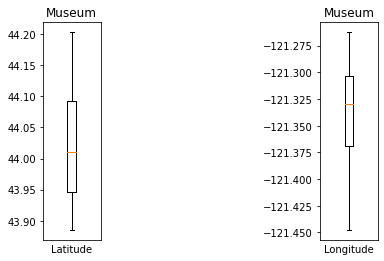

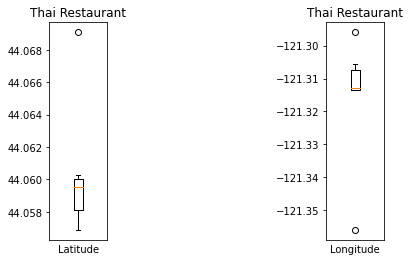

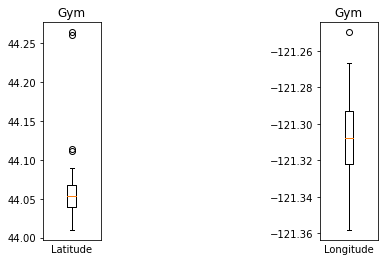

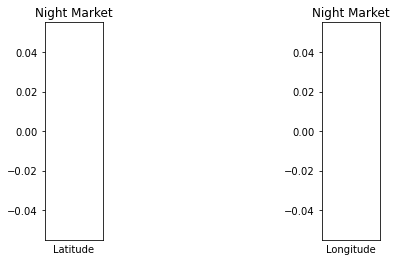

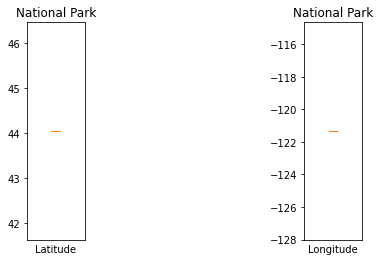

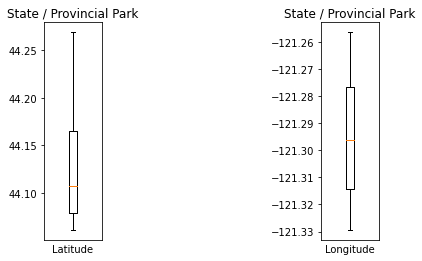

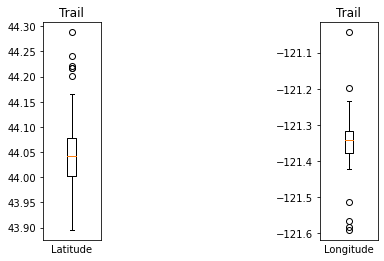

In [14]:
fnum=1

unique_cat=len(loc_venues['Category ID'].unique())+1
bp={}                                                   # Box plot object dict.

for i in range(0,unique_cat):
    plt.figure()
    plt.subplot(1,5,1)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Latitude']
    bp[categories[i]+'.Latitude']=(plt.boxplot(Y))
    plt.xlabel('Latitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

    plt.subplot(1,5,5)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Longitude']
    bp[categories[i]+'.Longitude']=(plt.boxplot(Y))
    plt.xlabel('Longitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

fnum=fnum+1

Remove the outliers from data, by referencing the category ID and latitude/longitude values

(77, 7)

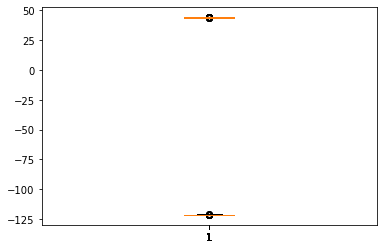

In [15]:
if remove_outliers=='Y':
    flag=1
    while flag==1:
        flag=0
        for category in categories:

            Y=loc_venues.loc[loc_venues['Category ID']==category,'Venue Latitude']
            bp[category+'.Latitude']=plt.boxplot(Y)
            Y=loc_venues.loc[loc_venues['Category ID']==category,'Venue Longitude']
            bp[category+'.Longitude']=plt.boxplot(Y)

            outliers_lat=bp[category+'.Latitude']['fliers'][0].get_data()[1]
            outliers_long=bp[category+'.Longitude']['fliers'][0].get_data()[1]
            if len(outliers_lat)>0 or len(outliers_long)>0:
                flag=1
            for outlier_lat in outliers_lat:
                idx1=loc_venues['Category ID']==category
                idx2=loc_venues['Venue Latitude']==outlier_lat
                idx1=idx1[idx1==True].index
                idx2=idx2[idx2==True].index
                loc_venues.drop(idx1.intersection(idx2),axis=0,inplace=True)
            for outlier_long in outliers_long:
                idx1=loc_venues['Category ID']==category
                idx2=loc_venues['Venue Longitude']==outlier_long
                idx1=idx1[idx1==True].index
                idx2=idx2[idx2==True].index
                loc_venues.drop(idx1.intersection(idx2),axis=0,inplace=True)
loc_venues.shape

Re-Plot the box plots to check that there are no outliers remaining

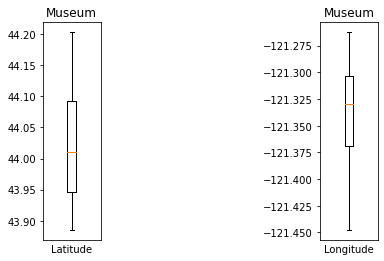

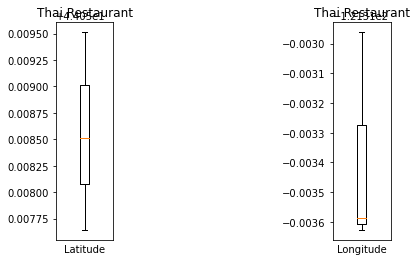

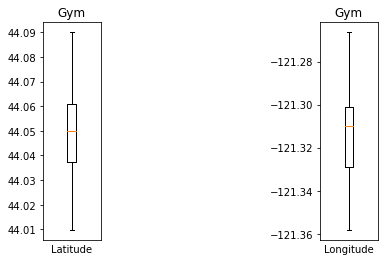

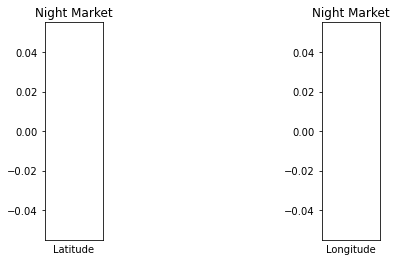

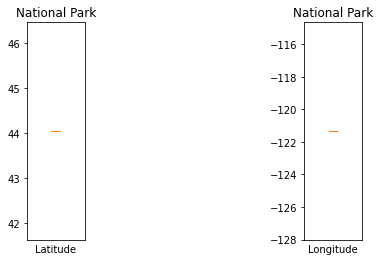

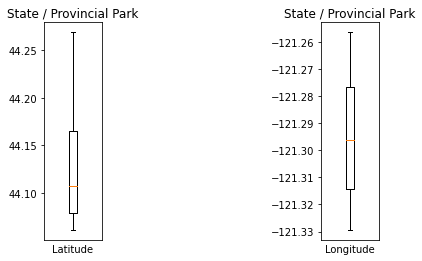

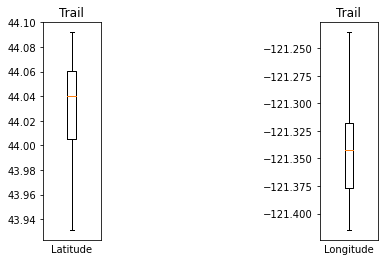

In [16]:
fnum=1

unique_cat=len(loc_venues['Category ID'].unique())+1
bp={}                                                   # Box plot object dict.

for i in range(0,unique_cat):
    plt.figure()
    plt.subplot(1,5,1)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Latitude']
    bp[categories[i]+'.Latitude']=(plt.boxplot(Y))
    plt.xlabel('Latitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

    plt.subplot(1,5,5)
    Y=loc_venues.loc[loc_venues['Category ID']==categories[i],'Venue Longitude']
    bp[categories[i]+'.Longitude']=(plt.boxplot(Y))
    plt.xlabel('Longitude')
    plt.xticks([])
    plt.title(str(cat_dict[categories[i]]))

fnum=fnum+1

Re-plot the folium plot

In [17]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for address in addresses:
    # create map
    clustered=loc_venues[loc_venues['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    venue_name=clustered.index
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid for '+str(address)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    

    # add markers to the map
    markers_colors = []
    for lat, lon, name in zip(lat_array, long_array, 
                                 venue_name     ):
        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
                            ).add_to(map_clusters)

    folium.RegularPolygonMarker(location=[latitude, longitude], popup='Centroid',
                         fill_color='yellow', radius=10).add_to(map_clusters)
    maps[address]=map_clusters
    i=i+1
lat2=latitude
long2=longitude
maps[addresses[-1]]

Centroid for Bend, Oregon at: 44.04606, -121.32722, Address: 345 SW Cyber Dr


### New dataframe for the venues with outliers removed and distance calculated from new centroid

In [18]:
loc_venues_new=getNearbyVenues(df_loc['Name'], loc_results_lat,loc_results_long,url_str,categories,radius)

loc_venues_new.head()

,Address,Venue,Venue_id,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,"Bend, Oregon",Des Chutes Historical Museum,4ccb7562063a721eb3ff879a,44.055381,-121.316909,History Museum,4bf58dd8d48988d181941735,1325
1,"Bend, Oregon",High Desert Museum,4b63435ff964a520656e2ae3,43.966331,-121.343029,Museum,4bf58dd8d48988d181941735,8965
2,"Bend, Oregon",Sunriver Observatory,4f125b2fe4b0a6ade14b6faf,43.885204,-121.447711,Science Museum,4bf58dd8d48988d181941735,20343
3,"Bend, Oregon",Petersen Rock Museum,4c3b80115810a593a9c4ba3c,44.203122,-121.262437,Public Art,4bf58dd8d48988d181941735,18233
4,"Bend, Oregon",Noi,505bb453e4b0236a2689ff75,44.057642,-121.313628,Thai Restaurant,4bf58dd8d48988d149941735,1686


In [19]:
# Find common venues between initial and outlier adjusted venue list
set_loc_venues=set(loc_venues['Venue_id'].tolist())
set_loc_venues_new=set(loc_venues_new['Venue_id'].tolist())
list_common_venues=list(set_loc_venues.intersection(set_loc_venues_new))

In [20]:
#Filter loc_venues_new to common venue ids
loc_venues_new=loc_venues_new.set_index(['Venue_id']).loc[list_common_venues,:].reset_index()
loc_venues_new.head()

,Venue_id,Address,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m]
0,4ba170e9f964a52057b737e3,"Bend, Oregon",Robert B. Sawyer State Park,44.083881,-121.309517,State / Provincial Park,5bae9231bedf3950379f89d0,4441
1,59a711d961f070506c20c711,"Bend, Oregon",Green Lakes Trailhead,44.042094,-121.338571,National Park,52e81612bcbc57f1066b7a21,1010
2,511ecb03e4b00145d5fbfae6,"Bend, Oregon",Crossfit Type 44,44.037811,-121.292675,Gym,4bf58dd8d48988d176941735,2912
3,5390ecd5498e1eb4652c4284,"Bend, Oregon",FIT PIT LLC,44.031700,-121.310120,Salon / Barbershop,4bf58dd8d48988d176941735,2104
4,528f76dc11d21a82a6b34706,"Bend, Oregon",inmotion,44.063121,-121.304363,Gym,4bf58dd8d48988d176941735,2636


In [21]:
#Sum of distances between centroid before and after removing outliers
dist_1=loc_venues['Distance [m]'].mean()/1000
print('Mean distance between venues and centroid is {} km.'.format(dist_1))
if remove_outliers=='Y':
    dist_2=loc_venues.set_index(['Venue_id']).loc[list_common_venues,:]['Distance [m]'].mean()/1000
    dist_3=loc_venues_new['Distance [m]'].mean()/1000
    # Print values
    print('Mean distance between non-outlier venues and centroid before removing outliers is {} km.'.format(dist_1))
    print('Mean distance between non-outlier venues and centroid after removing outliers is {} km.'.format(dist_2))
    print('Difference in mean distance between non-outlier venues and centroid before and after removing outliers is {} km'.
         format(dist_2-dist_3))
    print('Difference in mean distance between venues and centroid before and after removing outliers is {} km'.
         format(dist_1-dist_3))

Mean distance between venues and centroid is 4.5278311688311685 km.
Mean distance between non-outlier venues and centroid before removing outliers is 4.5278311688311685 km.
Mean distance between non-outlier venues and centroid after removing outliers is 4.272197368421052 km.
Difference in mean distance between non-outlier venues and centroid before and after removing outliers is 0.10176315789473644 km
Difference in mean distance between venues and centroid before and after removing outliers is 0.35739695830485285 km


### Geo-distance shift in coordinates

Define function to calculate distance based on geo-coordinates

In [22]:
def geodistance (coord1,coord2):
    R = 6373.0                          ## Radius of Earth in kms.
    latd1 = math.radians(coord1[0])     # Latitude of coord1 calculated in radians
    lon1 = math.radians(coord1[1])     # Longitude of coord1 calculated in radians
    latd2 = math.radians(coord2[0])     # Latitude of coord2 calculated in radians
    lon2 = math.radians(coord2[1])     # Longitude of coord2 calculated in radians

    dlon = lon2 - lon1
    dlat = latd2 - latd1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c * 1000                    # Geo-distance in kms.
    return distance

Distance shift in centroid after omitting the outliers:

In [23]:
shift_outlier=geodistance([lat1, long1],[lat2,long2])
print('Geo-Distance shift in Centroid before and after removing outliers is: '+str(round(shift_outlier/1000,2))+'kms.' )
for i in range(0,len(addresses)):
    shift_original=geodistance([df_loc.loc[i,'Latitude'],df_loc.loc[i,'Longitude']],[lat2,long2])
    print('Geo-Distance shift in Centroid for {} before and after processing is: {}'
          .format(addresses[i],str(round(shift_original/1000,2))+'kms.'))
    

Geo-Distance shift in Centroid before and after removing outliers is: 1.5kms.
Geo-Distance shift in Centroid for Bend, Oregon before and after processing is: 1.89kms.


## Encoding and Clustering

### Encoding by user specified category

In [24]:
# one hot encoding
loc_encoded=pd.get_dummies(loc_venues_new[['Category ID']], prefix="", prefix_sep="")   # Dataframe of encoding
loc_venues_encoded=pd.concat([loc_venues_new,loc_encoded],axis=1)                       # Encoded dataframe with venue details
loc_venues_encoded.head()

,Venue_id,Address,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m],4bf58dd8d48988d149941735,4bf58dd8d48988d159941735,4bf58dd8d48988d176941735,4bf58dd8d48988d181941735,52e81612bcbc57f1066b7a21,5bae9231bedf3950379f89d0
0,4ba170e9f964a52057b737e3,"Bend, Oregon",Robert B. Sawyer State Park,44.083881,-121.309517,State / Provincial Park,5bae9231bedf3950379f89d0,4441,0,0,0,0,0,1
1,59a711d961f070506c20c711,"Bend, Oregon",Green Lakes Trailhead,44.042094,-121.338571,National Park,52e81612bcbc57f1066b7a21,1010,0,0,0,0,1,0
2,511ecb03e4b00145d5fbfae6,"Bend, Oregon",Crossfit Type 44,44.037811,-121.292675,Gym,4bf58dd8d48988d176941735,2912,0,0,1,0,0,0
3,5390ecd5498e1eb4652c4284,"Bend, Oregon",FIT PIT LLC,44.031700,-121.310120,Salon / Barbershop,4bf58dd8d48988d176941735,2104,0,0,1,0,0,0
4,528f76dc11d21a82a6b34706,"Bend, Oregon",inmotion,44.063121,-121.304363,Gym,4bf58dd8d48988d176941735,2636,0,0,1,0,0,0


### Clustering by category encoding

In [25]:
# set number of clusters
kclusters = len(categories)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(loc_encoded)
# check cluster labels generated for each row in the dataframe
(kmeans.labels_)
# add clustering labels
loc_venues_clustered=loc_venues_encoded
loc_venues_clustered['Cluster Labels']= kmeans.labels_

# Display clustered dataframe
loc_venues_clustered.head(2)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)


,Venue_id,Address,Venue,Venue Latitude,Venue Longitude,Venue Category,Category ID,Distance [m],4bf58dd8d48988d149941735,4bf58dd8d48988d159941735,4bf58dd8d48988d176941735,4bf58dd8d48988d181941735,52e81612bcbc57f1066b7a21,5bae9231bedf3950379f89d0,Cluster Labels
0,4ba170e9f964a52057b737e3,"Bend, Oregon",Robert B. Sawyer State Park,44.083881,-121.309517,State / Provincial Park,5bae9231bedf3950379f89d0,4441,0,0,0,0,0,1,4
1,59a711d961f070506c20c711,"Bend, Oregon",Green Lakes Trailhead,44.042094,-121.338571,National Park,52e81612bcbc57f1066b7a21,1010,0,0,0,0,1,0,5


## Display Results

### Generate analyzed map array for each address using folium, and display centroid location for each address

In [26]:
maps={}
loc_results_lat=[]
loc_results_long=[]
zip_results={}

i=0
for address in addresses:
    # create map
    clustered=loc_venues_clustered[loc_venues_clustered['Address']==address]
    lat_array=clustered['Venue Latitude']
    long_array=clustered['Venue Longitude']
    
    # Calculate mean latitude and longitude
    latitude=lat_array.mean()                            
    longitude=long_array.mean()
    
    # Update results latitude and longitude arrays
    loc_results_lat.append(latitude)
    loc_results_long.append(longitude)
    
    # Obtain Zipcode
    url_zip=url_str_zip.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,500,1)
    zip_result=requests.get(url_zip).json()
    try:
        zip_results[address]=zip_result['response']['venues'][0]['location']['formattedAddress']
    except:
        zip_results[address]='0'
    
    print('Centroid for '+str(address)+' at: '+str(round(latitude,5))+', '+str(round(longitude,5))
          +', Address:',zip_results[address][0])

    map_clusters = folium.Map(location=[latitude, longitude],zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [j + x + (j*x)**2 for j in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(j) for j in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster, category in zip(lat_array, long_array, 
                                      clustered.index, clustered['Cluster Labels'], clustered['Category ID']):
        label = folium.Popup(str(poi) + ' Cluster: ' + str(cat_dict[category]), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7,
                            ).add_to(map_clusters)

    folium.RegularPolygonMarker(location=[latitude, longitude], popup='Centroid',
                         fill_color='yellow', radius=10).add_to(map_clusters)
    maps[address]=map_clusters
    i=i+1

Centroid for Bend, Oregon at: 44.04313, -121.32815, Address: 1000 SW Reed Market Rd (at Brookswood Blvd)


### Plot map

In [27]:
maps[addresses[-1]]

In [28]:
hotel_category=['4bf58dd8d48988d1fa931735']                # Category for Hotels

# Enter Hotel Search URL string
url_str_hotels='https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'

df_hotels=df_loc.copy()
df_hotels['Latitude']=latitude
df_hotels['Longitude']=longitude
                          # Radius in metres 
hotels=getNearbyVenues(names=df_hotels['Name'], latitudes=df_hotels['Latitude'],longitudes=df_hotels['Longitude'],
                       url_link=url_str_hotels,categories=hotel_category,radius=hotel_radius)
hotel_ids=hotels['Venue_id'].tolist()
likes_list=getVenueLikes(hotel_ids)

hotels['Likes']=likes_list

hotels.drop(columns=['Category ID','Address','Venue_id'],inplace=True)
hotels.sort_values(by=['Likes','Distance [m]'],ascending=[False,True],inplace=True)
hotels.reset_index(inplace=True,drop=True)

hotels

,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance [m],Likes
0,Sunriver Resort,43.873991,-121.446471,Resort,21080,82
1,The Riverhouse Hotel & Convention Center,44.079231,-121.305370,Hotel,4412,31
2,The Oxford Hotel,44.057747,-121.312222,Hotel,2066,18
3,Fairfield Inn & Suites Bend Downtown,44.066494,-121.308305,Hotel,3047,18
4,Tetherow Golf Club & Grill,44.024898,-121.365554,Golf Course,3616,17
5,Hilton Garden Inn,44.045293,-121.314651,Hotel,1106,16
6,DoubleTree by Hilton,44.056505,-121.311160,Hotel,2016,16
7,WorldMark Bend - Seventh Mountain Resort,43.996047,-121.397476,Hotel,7633,16
8,Mount Bachelor Village Resort,44.032860,-121.336124,Resort,1309,13
9,Hampton Inn by Hilton,44.044355,-121.318257,Hotel,803,10
